In [28]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Ground truth models
analysis_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/ground_truth_analysis_732x7x49x69.nc')
analysis = {
    'name': 'analysis',
    'data': analysis_data
}

# era_ground_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data\ground_truth_era5_732x7x49x69.nc')
# era_ground = {
#     'name': 'era_ground',
#     'data': era_ground_data

# }

# NWP models
hres_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data\hres_732x7x49x69.nc')
hres = {
    'name': 'hres',
    'data': hres_data
}

era5_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data\era5_732x7x49x69.nc')
era5 = {
    'name': 'era5',
    'data': era5_data
}

# AIWP models
graphcast_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/graphcast_732x7x49x69.nc')
graphcast = {
    'name': 'graphcast',
    'data': graphcast_data
}

fuxi_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/fuxi_702x7x49x69.nc')
fuxi = {
    'name': 'fuxi',
    'data': fuxi_data
}

keisler_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/keisler_732x7x13x18.nc')
keisler = {
    'name': 'keisler',
    'data': keisler_data
}

pangu_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/pangu_732x7x49x69.nc')
pangu = {
    'name': 'pangu',
    'data': pangu_data
}


In [81]:
class Metric:
    def __init__(self, base, test):
        self.base_name = base['name']
        self.test_name = test['name']

        self.base = base['data'].load()
        self.test = test['data'].load()

        self.base = self.base.dropna('time')
        self.test = self.test.dropna('time')

        self.results = {
            'hres': [],
            'era5': [],
            'graphcast': [],
            'fuxi': [],
            'keisler': [],
            'pangu': []
        }

        self.align_datasets()
    
    def align_datasets(self):
        if not np.array_equal(self.base.time, self.test.time):
            print('\tAligning datasets on time dimension')
            common_times = np.intersect1d(self.base.time, self.test.time)
            self.base = self.base.sel(time=common_times)
            self.test = self.test.sel(time=common_times)

        if not np.array_equal(self.base.latitude, self.test.latitude) or not np.array_equal(self.base.longitude, self.test.longitude):
            print('\tTest regrid to base coordinates')
            self.test = self.test.interp(latitude=self.base.latitude, longitude=self.base.longitude)

        if self.test.prediction_timedelta.size == 7:
            self.test = self.test.isel(prediction_timedelta=slice(1, 7))

        if  self.base.prediction_timedelta.size != self.test.prediction_timedelta.size:
            print('\tAligning datasets on prediction_timedelta dimension')
            self.base = self.base.sel(prediction_timedelta=self.test.prediction_timedelta)
    
    def spatial_bias(self):
        return (self.base - self.test)
    
    def spatial_mae(self):
       return abs(self.spatial_bias())
    
    def spatial_mse(self):
        return (self.spatial_bias()**2)
    
    def spatial_rmse(self):
        return (self.spatial_mse())**0.5
    
    def spatial_mape(self):
        return abs(self.spatial_bias()/self.base)
    
    def spatial_rmspe(self):
        return (self.spatial_mape()**2)**0.5
    
    def bias(self):
        return spatial_average(self.spatial_bias())
    
    def mae(self):
        mae = spatial_average(self.spatial_mae())
        return mae.mean(dim='time')
    
    def mse(self):
        mse = spatial_average(self.spatial_mse())
        return mse.mean(dim='time')
    
    def rmse(self):
        rmse = spatial_average(self.spatial_rmse())
        return rmse.mean(dim='time')
    
    def mape(self):
        mape = spatial_average(self.spatial_mape())
        return mape.mean(dim='time')
    
    def rmspe(self):
        rmspe = spatial_average(self.spatial_rmspe())
        return rmspe.mean(dim='time')

    def correlation(self):
        correlations = []
        for timedelta in range(self.base.prediction_timedelta.size):
            corr = np.corrcoef(self.base.wind_speed.values[:, timedelta].flatten(), self.test.wind_speed.values[:, timedelta].flatten())[0, 1]
            correlations.append(corr)
        
        return np.array(correlations)
    
def spatial_average(dataset: xr.Dataset):
    # TODO: Weighted along latitude/longitude
    return dataset.mean(dim=['latitude', 'longitude']).dropna('time')


In [83]:
models = [hres, era5, graphcast, fuxi, keisler, pangu]

available_metrics = {
    'spatial_bias': Metric.spatial_bias,
    'spatial_mae': Metric.spatial_mae,
    'spatial_mse': Metric.spatial_mse,
    'spatial_rmse': Metric.spatial_rmse,
    'spatial_mape': Metric.spatial_mape,
    'spatial_rmspe': Metric.spatial_rmspe,
    'bias': Metric.bias,
    'mae': Metric.mae,
    'mse': Metric.mse,
    'rmse': Metric.rmse,
    'mape': Metric.mape,
    'rmspe': Metric.rmspe,
    'correlation': Metric.correlation
}


def calculate_metric(models, metric, available_metrics=available_metrics):    
    results = {
        'hres': [],
        'era5': [],
        'graphcast': [],
        'fuxi': [],
        'keisler': [],
        'pangu': []
    }

    for model in models:
        
        print(f'Calculating {metric} for {model["name"]}')
        
        metrics = Metric(analysis, model)
        
        error_metric = available_metrics[metric](metrics)
        
        results[metrics.test_name].append(error_metric.wind_speed.values)
    
    return results

def calculate_correlation(models):
    results = {
        'hres': [],
        'era5': [],
        'graphcast': [],
        'fuxi': [],
        'keisler': [],
        'pangu': []
    }

    for model in models:
        print(f'Calculating correlation for {model["name"]}')
        
        metrics = Metric(analysis, model)
        
        correlations = metrics.correlation()
        
        results[metrics.test_name].append(correlations)
    
    return results

mae = calculate_metric(models, 'mae')
rmse = calculate_metric(models, 'rmse')
mape = calculate_metric(models, 'mape')
rmspe = calculate_metric(models, 'rmspe')
correlation = calculate_correlation(models)

Calculating mae for hres
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating mae for era5
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating mae for graphcast
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating mae for fuxi
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating mae for keisler
	Aligning datasets on time dimension
	Test regrid to base coordinates
	Aligning datasets on prediction_timedelta dimension
Calculating mae for pangu
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating rmse for hres
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating rmse for era5
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating rmse for graphcast
	Alig

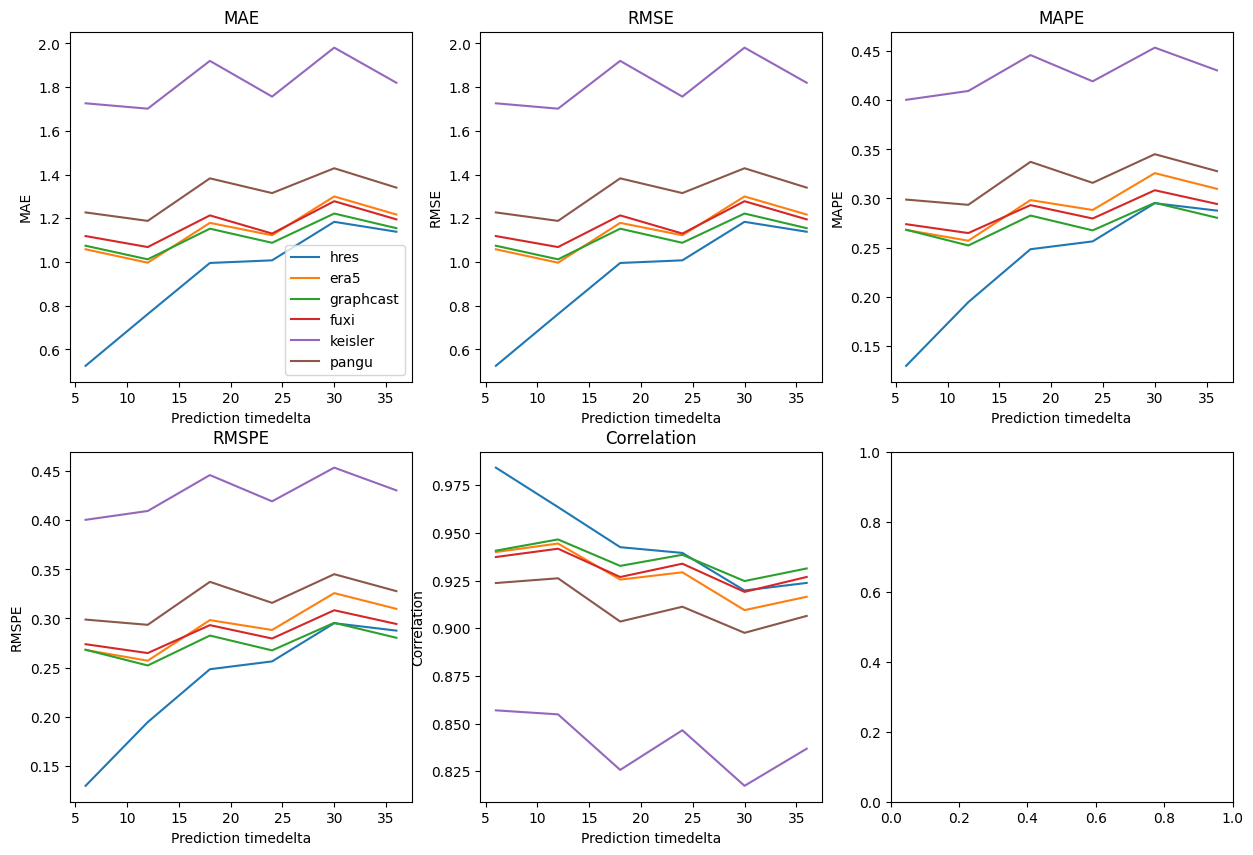

In [87]:
# Plotting

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

x_lin = np.arange(6 , 37, 6)

for i, model in enumerate(models):
    axs[0, 0].plot(x_lin, mae[model['name']][0], label=model['name'])
    axs[0, 0].set_title('MAE')
    axs[0, 0].set_xlabel('Prediction timedelta')
    axs[0, 0].set_ylabel('MAE')

    axs[0, 1].plot(x_lin, rmse[model['name']][0], label=model['name'])
    axs[0, 1].set_title('RMSE')
    axs[0, 1].set_xlabel('Prediction timedelta')
    axs[0, 1].set_ylabel('RMSE')

    axs[0, 2].plot(x_lin, mape[model['name']][0], label=model['name'])
    axs[0, 2].set_title('MAPE')
    axs[0, 2].set_xlabel('Prediction timedelta')
    axs[0, 2].set_ylabel('MAPE')

    axs[1, 0].plot(x_lin, rmspe[model['name']][0], label=model['name'])
    axs[1, 0].set_title('RMSPE')
    axs[1, 0].set_xlabel('Prediction timedelta')
    axs[1, 0].set_ylabel('RMSPE')

    axs[1, 1].plot(x_lin, correlation[model['name']][0], label=model['name'])
    axs[1, 1].set_title('Correlation')
    axs[1, 1].set_xlabel('Prediction timedelta')
    axs[1, 1].set_ylabel('Correlation')


axs[0, 0].legend()
plt.show()

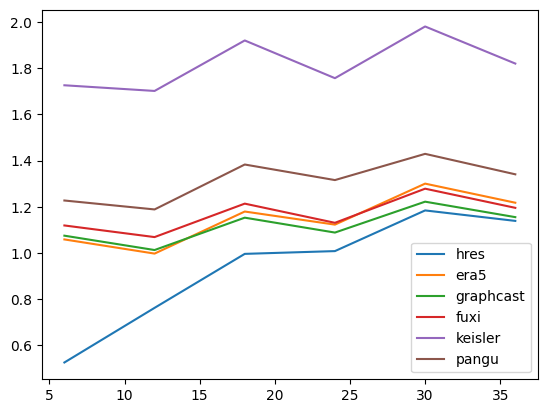

In [47]:
x_lin = np.arange(6, 37, 6)
for model in models:
    plt.plot(x_lin, mae[model['name']][0], label=model['name'])

plt.legend()
plt.show()
